## Feature Selection

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2022_10_22', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='2023_04_01', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse')]

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when

spark.sql("USE 2023_04_01")


DataFrame[]

### Investigating metrics that changed the most before and after implosions

In [5]:

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df

In [42]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when
import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt



def query(ticker):
    query = f"""SELECT d.ticker_region, a.date
                FROM FF_ADVANCED_AF a 
                LEFT JOIN sym_ticker_region d ON d.fsym_id = a.fsym_id 
                WHERE d.ticker_region = "{ticker}-US"
                ORDER BY a.date
                """

    fund_df = spark.sql(query)
    fund_df = fund_df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    
    return fund_df

def get_top_bottom_ten(df):
    df = df.sort_values(by='Value')
    df=df.dropna()
    top10 = df.head(10)
    down10 = df.tail(10)
    print(top10,down10)
    return top10['Metric'].tolist(), down10['Metric'].tolist()

def avg_change_df(df, big_string, big_string2, avg_string):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.Ticker, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON t.Ticker = SUBSTRING(s.ticker_region, 1, LENGTH(s.ticker_region)-3) AND SUBSTRING(s.ticker_region, -2, 3) = 'US'
                LEFT JOIN FF_ADVANCED_AF a ON s.fsym_id = a.fsym_id AND a.date < t.Implosion_Date
                GROUP BY t.Ticker
                ORDER BY t.Ticker
            """
    query2 = f"""
                SELECT {avg_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON t.Ticker = SUBSTRING(s.ticker_region, 1, LENGTH(s.ticker_region)-3) AND SUBSTRING(s.ticker_region, -2, 3) = 'US'
                LEFT JOIN FF_ADVANCED_AF a ON s.fsym_id = a.fsym_id AND a.date > t.Implosion_Date
                GROUP BY t.Ticker
                ORDER BY t.Ticker
            """
    df1 = spark.sql(query1)
    df2 = spark.sql(query2)
    print(df1.show(5))
    
    df1 = df1.toPandas()
    df2 = df2.toPandas()
    
    non_string_columns = df1.select_dtypes(exclude=['object']).columns
    df1 = df1[non_string_columns]
    df2 = df2[non_string_columns]
    
    null_threshold = 200
    columns_to_drop = df1.columns[df1.isnull().sum() > null_threshold]
    df1 = df1.drop(columns=columns_to_drop)
    df2 = df2.drop(columns=columns_to_drop)
    # print("NULLS:")
    # print(df1.isnull().sum())
    # print(df2.isnull().sum())
    
    percentage_change_df = ((df1 - df2) / df2) * 100
    #print(percentage_change_df)
    #print("LENGTH: ",len(percentage_change_df))
    
    
    metric_dict = {}
    for column in percentage_change_df.columns:
        percentage_change_df[column] = percentage_change_df[column].replace([np.inf, -np.inf], np.nan)
        new_col = percentage_change_df[column].dropna()
        mean_val = new_col.mean()
        stddev_val = new_col.std()
        z_score_threshold = 3.0
        new_col = new_col[(new_col >= mean_val - z_score_threshold * stddev_val) &
        (new_col <= mean_val + z_score_threshold * stddev_val)]
        #if new_col.std() < 1000:
        metric_dict[column] = new_col.mean()
    #print(metric_dict)
    metric_df = pd.DataFrame(list(metric_dict.items()), columns=['Metric', 'Value'])
    #metric_df.to_csv('ChangesBeforeImplosionA4yrs.csv', index=False)
    return metric_df

def pct_change_df(df, big_string, big_string2):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON t.Ticker = SUBSTRING(s.ticker_region, 1, LENGTH(s.ticker_region)-3) AND SUBSTRING(s.ticker_region, -2, 3) = 'US'
                LEFT JOIN FF_ADVANCED_AF a ON s.fsym_id = a.fsym_id AND YEAR(a.date) = YEAR(t.Implosion_Date)
                ORDER BY t.Ticker
            """
    query2 = f"""
                SELECT {big_string2}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON t.Ticker = SUBSTRING(s.ticker_region, 1, LENGTH(s.ticker_region)-3) AND SUBSTRING(s.ticker_region, -2, 3) = 'US'
                LEFT JOIN FF_ADVANCED_AF b ON s.fsym_id = b.fsym_id AND YEAR(b.date) = YEAR(t.Implosion_Prev4Years)
                ORDER BY t.Ticker
            """
    df1 = spark.sql(query1)
    df2 = spark.sql(query2)
    
    df1 = df1.toPandas()
    df2 = df2.toPandas()
    
    non_string_columns = df1.select_dtypes(exclude=['object']).columns
    df1 = df1[non_string_columns]
    df2 = df2[non_string_columns]
    
    null_threshold = 200
    columns_to_drop = df1.columns[df1.isnull().sum() > null_threshold]
    df1 = df1.drop(columns=columns_to_drop)
    df2 = df2.drop(columns=columns_to_drop)
    # print("NULLS:")
    # print(df1.isnull().sum())
    # print(df2.isnull().sum())
    
    percentage_change_df = ((df1 - df2) / df2) * 100
    #print(percentage_change_df)
    #print("LENGTH: ",len(percentage_change_df))
    
    
    metric_dict = {}
    for column in percentage_change_df.columns:
        percentage_change_df[column] = percentage_change_df[column].replace([np.inf, -np.inf], np.nan)
        new_col = percentage_change_df[column].dropna()
        mean_val = new_col.mean()
        stddev_val = new_col.std()
        z_score_threshold = 3.0
        new_col = new_col[(new_col >= mean_val - z_score_threshold * stddev_val) &
        (new_col <= mean_val + z_score_threshold * stddev_val)]
        #if new_col.std() < 1000:
        metric_dict[column] = new_col.mean()
    #print(metric_dict)
    metric_df = pd.DataFrame(list(metric_dict.items()), columns=['Metric', 'Value'])
    #metric_df.to_csv('ChangesBeforeImplosionA4yrs.csv', index=False)
    return metric_df
    
    # df['pct_change'] = (df[metric_curr] - df[metric_prev])/df[metric_prev]
    # df['pct_change'] = df['pct_change'].replace([np.inf, -np.inf], np.nan) 
    # df=df.dropna(axis=0)
    # mean_val = df['pct_change'].mean()
    # stddev_val = df['pct_change'].std()
    # z_score_threshold = 3.0
    # df = df[
    # (df['pct_change'] >= mean_val - z_score_threshold * stddev_val) &
    # (df['pct_change'] <= mean_val + z_score_threshold * stddev_val)]
    # new_mean = df['pct_change'].mean()
    # return new_mean




def get_metric_changes(filename):
    df = pd.read_csv(filename, index_col=False)
    df['Implosion_Date'] = pd.to_datetime(df['Implosion_Date']).dt.date
    df_metrics = spark.sql("SELECT * FROM FF_ADVANCED_AF LIMIT 10")
    df_metrics = df_metrics.columns[:5]
    result_string = ', '.join('a.' + item for item in df_metrics)
    result_string2 = ', '.join('b.' + item for item in df_metrics)
    result_list = result_string.split(',')
    avg_string =  [f'AVG({element})' for element in result_list]
    avg_string = ', '.join(avg_string)
    top10s = []
    bottom10s = []
    for y in range(1,2):
        #df['Implosion_Prev4Years'] = df['Implosion_Date'] - pd.DateOffset(years=y)
    #print(result_string)
        new_df = avg_change_df(df, result_string, result_string2, avg_string)
        top10, bottom10 = get_top_bottom_ten(new_df)
        top10s.append(top10)
        bottom10s.append(bottom10)
    return top10s,bottom10s


# tops, bottoms = get_metric_changes('imploded_tickers_dates.csv')


### Correlations with Price

In [95]:
import csv

def consistent_changes(ticker, big_string):
    start_date = pd.to_datetime("2009-01-01")
    query1 = f"""
                SELECT b.FF_PRICE_CLOSE_FP, {big_string}
                FROM FF_ADVANCED_AF a
                LEFT JOIN sym_ticker_region d ON d.fsym_id = a.fsym_id
                LEFT JOIN FF_BASIC_QF b ON b.date=a.date AND d.fsym_id=b.fsym_id
                WHERE d.ticker_region = "{ticker}-US" 
                AND a.date >= "{start_date}"
                ORDER BY a.date
            """
    q_df = spark.sql(query1)
    print("query done")
    q_df = ps.DataFrame(q_df)
    non_string_columns = q_df.select_dtypes(exclude=['object']).columns
    q_df = q_df[non_string_columns]
    print("filtering done")
    # null_threshold = 10
    # columns_to_drop = q_df.columns[q_df.isnull().sum() > null_threshold]
    # q_df = q_df.drop(columns=columns_to_drop)
    correlations = q_df.corr()['FF_PRICE_CLOSE_FP']
    print("corr done")
    return correlations

def get_not_null_cols(df, col_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    start_date = pd.to_datetime("2009-01-01")
    query1 = f"""
                SELECT t.Ticker, a.date, {col_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.ticker_region = CONCAT(t.Ticker, '-US')
                LEFT JOIN {table} a ON s.fsym_id=a.fsym_id
                WHERE a.date >= "{start_date}"
                ORDER BY t.Ticker, a.date
            """
    q_df = spark.sql(query1)
    q_df = ps.DataFrame(q_df)
    null_pcts = q_df.isnull().sum()/len(q_df)
    #print(null_pcts)
    cols = null_pcts[null_pcts <= 0.5].index.tolist()
    cols.remove('Ticker')
    cols.remove('date')
    #print(len(cols))
    return cols
    

def corr_query(implosion_df, col_string, table):
    df=spark.createDataFrame(implosion_df)
    df.createOrReplaceTempView("temp_table")
    start_date = pd.to_datetime("2009-01-01")
    query1 = f"""
                SELECT t.Ticker, {col_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.ticker_region = CONCAT(t.Ticker, '-US')
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id
                LEFT JOIN FF_BASIC_QF b ON b.date=a.date AND s.fsym_id=b.fsym_id
                WHERE a.date >= "{start_date}"
                GROUP BY t.Ticker
                ORDER BY t.Ticker
            """
    # query1 = f"""
    #             SELECT t.Ticker, {col_string}
    #             FROM temp_table t
    #             LEFT JOIN sym_ticker_region s ON s.ticker_region = CONCAT(t.Ticker, '-US')
    #             LEFT JOIN {table} a ON s.fsym_id=a.fsym_id
    #             WHERE a.date >= "{start_date}"
    #             GROUP BY t.Ticker
    #             ORDER BY t.Ticker
    #         """
    q_df = spark.sql(query1)
    q_df = ps.DataFrame(q_df)
    
    mean_vals = q_df.mean()
    mean_vals = mean_vals.sort_values()
    return mean_vals

def corr_analysis(filename,table):
    #df = pd.read_csv(filename, index_col=False)
    with open('all_stocks.csv', mode='r') as file:
        reader = csv.reader(file)
        ticker_list = next(reader, None)
    df=pd.DataFrame(ticker_list, columns=['Ticker'])
    #df['Implosion_Date'] = pd.to_datetime(df['Implosion_Date']).dt.date
    df_metrics = ps.DataFrame(spark.sql(f"SELECT * FROM {table} LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    norm_string = ', '.join('a.' + item for item in cols)
    cols = get_not_null_cols(df, norm_string, table)
    corr_string = ', '.join('CORR(a.' + item + ', FF_PRICE_CLOSE_FP)' for item in cols) #make a dynamic string for the SQL query
    mean_vals=corr_query(df, corr_string, table)
    mean_vals=mean_vals.dropna()
    print("Top 10: ", mean_vals.head(10))
    print("Bottom 10: ", mean_vals.tail(10))
    
    

    
    
#corr_analysis('all_stocks.csv', 'FF_Advanced_Der_QF')

    year  ff_gross_inc_percentage_change  ff_sales_percentage_change  \
0   2009                             NaN                    0.000000   
1   2010                       53.233861                 7789.421624   
2   2011                       52.403966                    4.765310   
3   2012                       20.987422                    3.329479   
4   2013                       16.101210                    2.138241   
5   2014                        0.323935                    7.119225   
6   2015                     -166.976477                   15.236055   
7   2016                       10.549680                   10.505098   
8   2017                        3.951588                   13.197693   
9   2018                       -6.491872                   16.977096   
10  2019                        5.323128                   13.695219   
11  2020                       -2.040373                    8.669726   
12  2021                   -21198.990060                    4.51

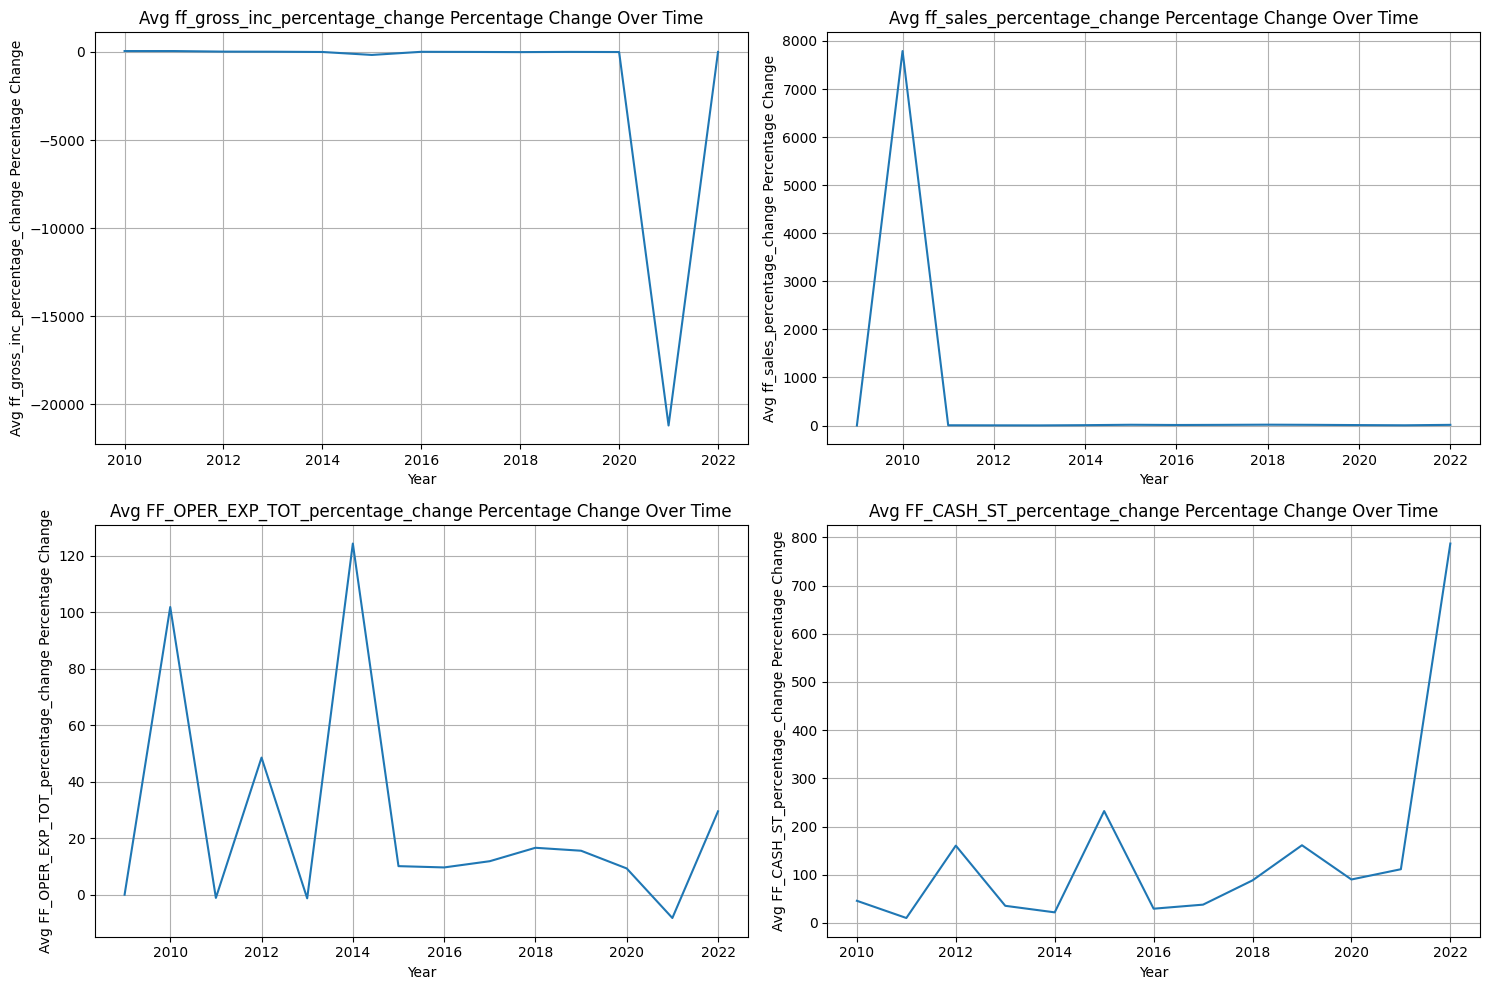

In [62]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols


def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

industry_analysis()

In [ ]:
def get_top_bottom_five(df):
    df = df.sort_values(by='Value')
    df=df.dropna()
    top5 = df.head(10)
    down5 = df.tail(10)
    print(top5)
    print(down5)
    print(len(df))


df = pd.read_csv('Avg_Correlations.csv', index_col=None)
get_top_bottom_five(df)
#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF

In [ ]:
metric_df

In [ ]:
metric_dict